In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as  dt
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [ ]:
#goog = yf.Ticker("GOOG")
#data = goog.history(period = "500d")

ticker = 'GOOG'
a1 = yf.Ticker(ticker)
data = a1.history(period="500d" , interval = '1d')

In [ ]:
data['HA_close'] = 0
data['HA_open'] = 0
data['HA_high'] = 0
data['HA_low'] = 0

In [ ]:
high = data['High']
low = data['Low']
close = data['Close']
Open = data['Open']
HA_close = data['HA_close'] 
HA_open = data['HA_open']
HA_high = data['HA_high']
HA_low = data['HA_low']

In [ ]:
for i in range(1, len(data.index)-1):
    curr, prev = i, i-1
    a = [high[curr], low[curr], close[curr]]
    b = [low[curr], Open[curr], close[curr]]
    HA_close[curr] = (Open[curr]+high[curr]+low[curr]+close[curr])/4
    HA_open[curr] = (Open[prev] + close[prev])/2
    HA_high[curr] = max(a)
    HA_low[curr] = min(b)

In [ ]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,HA_close,HA_open,HA_high,HA_low
Date,,,,,,,,,,,
2020-08-18,76.308998,78.123497,76.185501,77.930000,40542000,0,0.0,0,0,0,0
2020-08-19,77.665497,78.683998,77.197502,77.376503,33212000,0,0.0,77,77,78,77
2020-08-20,77.172501,79.293503,76.910004,79.087502,34138000,0,0.0,78,77,79,76
2020-08-21,78.851501,79.886002,78.400253,79.021004,28930000,0,0.0,79,78,79,78
2020-08-24,79.698997,80.708504,79.028503,79.410004,28198000,0,0.0,79,78,80,79
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-05,116.930000,118.860001,116.709999,118.220001,15607600,0,0.0,117,118,118,116
2022-08-08,119.120003,120.860001,117.830002,118.139999,17061100,0,0.0,118,117,120,117
2022-08-09,117.989998,118.199997,116.559998,117.500000,15424300,0,0.0,117,118,118,116


In [ ]:
data.Close.loc[data.index[1]]

77.37650299072266

#Strategy 1 : Supertrend

In [ ]:
def Supertrend(df, atr_period, multiplier):
    
    high = df['HA_high']
    low = df['HA_low']
    close = df['HA_close']
    
    # calculate ATR
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    # df['atr'] = df['tr'].rolling(atr_period).mean()
    
    # HL2 is simply the average of high and low prices
    hl2 = (high + low) / 2
    # upperband and lowerband calculation
    # notice that final bands are set to be equal to the respective bands
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    # initialize Supertrend column to True
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]
            
            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        # to remove bands according to the trend direction
        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)
    

In [ ]:
atr_period = 10
atr_multiplier = 3.0
supertrend = Supertrend(data, atr_period, atr_multiplier)
data = data.join(supertrend)

In [ ]:
data.head(15)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,HA_close,HA_open,HA_high,HA_low,Supertrend,Final Lowerband,Final Upperband
Date,,,,,,,,,,,,,,
2020-08-18,76.308998,78.123497,76.185501,77.930000,40542000,0,0.0,0,0,0,0,True,NaN,NaN
2020-08-19,77.665497,78.683998,77.197502,77.376503,33212000,0,0.0,77,77,78,77,True,NaN,NaN
2020-08-20,77.172501,79.293503,76.910004,79.087502,34138000,0,0.0,78,77,79,76,True,NaN,NaN
2020-08-21,78.851501,79.886002,78.400253,79.021004,28930000,0,0.0,79,78,79,78,True,NaN,NaN
2020-08-24,79.698997,80.708504,79.028503,79.410004,28198000,0,0.0,79,78,80,79,True,NaN,NaN
2020-08-25,79.103500,80.581001,79.103500,80.411003,44942000,0,0.0,79,79,80,79,True,NaN,NaN
2020-08-26,80.400002,82.960999,80.180000,82.619003,79868000,0,0.0,81,79,82,80,True,NaN,NaN
2020-08-27,82.683998,82.750000,81.287498,81.716499,37232000,0,0.0,82,81,82,81,True,NaN,NaN
2020-08-28,81.674500,82.358498,81.537498,82.220497,29980000,0,0.0,81,82,82,81,True,NaN,NaN


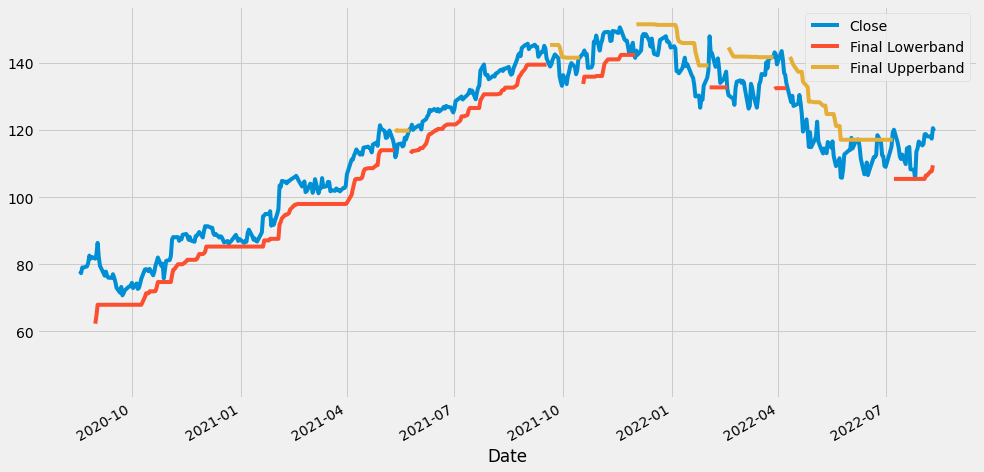

In [ ]:
data[['Close', 'Final Lowerband', 'Final Upperband']].plot(figsize = (15,8))

In [ ]:
import time

In [ ]:
len(data)

500

In [ ]:
data.index[-1].date()

datetime.date(2022, 8, 11)

In [ ]:
import math

In [ ]:
def backtest_supertrend(df, investment):
    is_uptrend = df['Supertrend']
    close = df['Close']
    
    # initial condition
    in_position = False
    equity = investment
    share = 0
    entry = []
    exit = []
    
    for i in range(2, len(df)):
        # if not in position & price is on uptrend -> buy
        if not in_position and is_uptrend[i]:
            share = math.floor(equity / close[i] / 100) * 100
            equity -= share * close[i]
            entry.append((i, close[i]))
            in_position = True
            print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
        # if in position & price is not on uptrend -> sell
        elif in_position and not is_uptrend[i]:
            equity += share * close[i]
            exit.append((i, close[i]))
            in_position = False
            print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
    # if still in position -> sell all share 
    if in_position:
        equity += share * close[i]
    
    earning = equity - investment
    roi = round(earning/investment*100,2)
    print(f'Earning from investing 400000 is {round(earning,2)} (ROI = {roi}%)')
    return entry, exit, equity

In [ ]:
entry, exit, roi = backtest_supertrend(data, 400000)

Buy 5000 shares at 79.09 on 2020/08/20
Sell at 111.95 on 2021/05/12
Buy 4600 shares at 120.45 on 2021/05/25
Sell at 139.02 on 2021/09/20
Buy 4500 shares at 142.96 on 2021/10/18
Sell at 143.78 on 2021/12/02
Buy 4400 shares at 148.04 on 2022/02/02
Sell at 130.47 on 2022/02/18
Buy 4000 shares at 143.25 on 2022/03/29
Sell at 129.8 on 2022/04/11
Buy 4300 shares at 120.17 on 2022/07/08
Sell at 119.82 on 2022/08/11
Earning from investing 400000 is 120780.45 (ROI = 30.2%)


In [ ]:
hit_rate = round(3/6,3)
print('The hit rate is {}'.format(hit_rate))

The hit rate is 0.5


#Strategy 2: RSI

In [ ]:
from math import floor
from termcolor import colored as cl 

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [ ]:
aapl = yf.Ticker("AAPL")
data1 = aapl.history(period = "500d")

In [ ]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

data1['rsi_14'] = get_rsi(data1['Close'], 14)
data1 = data1.dropna()
data1

,Open,High,Low,Close,Volume,Dividends,Stock Splits,rsi_14
Date,,,,,,,,
2020-08-24,127.162477,127.248942,122.459256,124.356354,345937600,0.00,0.0,100.000000
2020-08-25,123.210185,123.686928,121.584801,123.336159,211495600,0.00,0.0,90.809070
2020-08-26,124.674991,125.477800,123.590578,125.013405,163022400,0.00,0.0,92.095362
2020-08-27,125.626016,125.964429,122.355491,123.518951,155552400,0.00,0.0,81.191926
2020-08-28,124.509500,124.934372,123.091618,123.318878,187630000,0.00,0.0,79.829292
...,...,...,...,...,...,...,...,...
2022-08-05,163.210007,165.850006,163.000000,165.350006,56646600,0.23,0.0,69.662751
2022-08-08,166.369995,167.809998,164.199997,164.869995,60276900,0.00,0.0,68.547096
2022-08-09,164.020004,165.820007,163.250000,164.919998,63135500,0.00,0.0,68.603504


In [ ]:
data = data1
position=0
position_index=0
realised_pnl=0
number_of_trades=0
pnl_l = 0
pnl_h = 0
pnl_l1 = []
position_l = []
tradebook = {}

for i in range(len(data)):

    if ((position == 0)& (data.rsi_14.loc[data.index[i]] < 30 ) ):
            position_time=data.index[i].time()
            position_index=data.index[i]
            entry_price = data.loc[data.index[i+1],'Open']
            position = 1
            print('long position at {}'.format(data.index[i].date()))
            number_of_trades=number_of_trades+1
            position_l.append(position_index)
            continue
    if ((position == 0)& (data.rsi_14.loc[data.index[i]] > 70) ):
            position_time=data.index[i].time()
            position_index=data.index[i]
            entry_price = data.loc[data.index[i+1],'Open']
            position = -1
            print('short position at {}'.format(data.index[i].date()))
            number_of_trades=number_of_trades+1
            position_l.append(position_index)
            continue


    if (position_index!=0):

        pnl = ((data.loc[data.index[i],'Close']- entry_price)/entry_price)*(position)*100  
        

    if ((position != 0) and ((pnl  > entry_price*0.1 ) or (pnl < -entry_price*0.1))):
        realised_pnl=realised_pnl+pnl
        pnl_l1.append(pnl)
        position=0
        print('position exited at {}'.format(data.index[i].date()))
        position_index=0
        tradebook[number_of_trades] = {'entry_time' :position_time ,'entry_price': entry_price ,'long_short': position ,'exit_time' :data.index[i], 'pnl' :pnl}
        print(pnl)
    if ((position != 0) and (data.index[i].date()) > data.index[-1].date()):
        realised_pnl=realised_pnl+pnl
        pnl_l1.append(pnl)
        tradebook[number_of_trades] = {'entry_time' :position_time ,'entry_price': entry_price ,'long_short': position ,'exit_time' :data.index[i], 'pnl' :pnl}
        position=0
        print('position covered at {}'.format(data.index[i].date()))
        position_index=0
        print(pnl)
        pnl = 0
print(realised_pnl)

short position at 2020-08-24
position exited at 2020-09-18
14.320665517957188
short position at 2020-12-28
position exited at 2021-03-08
15.585749010662376
short position at 2021-06-30
position exited at 2021-09-07
-14.879050163608165
short position at 2021-11-18
position exited at 2022-06-13
16.116682581054437
short position at 2022-07-29
31.144046946065835


In [ ]:
position_l

[Timestamp('2020-08-24 00:00:00'),
 Timestamp('2020-12-28 00:00:00'),
 Timestamp('2021-06-30 00:00:00'),
 Timestamp('2021-11-18 00:00:00'),
 Timestamp('2022-07-29 00:00:00')]

In [ ]:
tradebook_df = pd.DataFrame(tradebook).T
tradebook_df['Profit'] = (tradebook_df['entry_price']*tradebook_df['pnl'])/100

In [ ]:
tradebook_df

,entry_time,entry_price,long_short,exit_time,pnl,Profit
1,00:00:00,123.210185,0,2020-09-18,14.320666,17.644518
2,00:00:00,136.638756,0,2021-03-08,15.585755,21.296181
3,00:00:00,135.635605,0,2021-09-07,-14.879039,-20.181274
4,00:00:00,157.000324,0,2022-06-13,16.116691,25.303256


In [ ]:
realised_pnl

31.14407178485148

In [ ]:
hit_rate = round(3/4,3)
print('The hit rate is {}'.format(hit_rate))

The hit rate is 0.75
